In [1]:
import pyrosetta
import pyrosetta_help as ph
from types import ModuleType
from IPython.display import display, HTML
prc: ModuleType = pyrosetta.rosetta.core
prp: ModuleType = pyrosetta.rosetta.protocols
pru: ModuleType = pyrosetta.rosetta.utility
prcc: ModuleType = pyrosetta.rosetta.core.conformation
pr_conf: ModuleType = pyrosetta.rosetta.core.conformation
pr_scoring: ModuleType = pyrosetta.rosetta.core.scoring
pr_options: ModuleType = pyrosetta.rosetta.basic.options
pr_res: ModuleType = pyrosetta.rosetta.core.select.residue_selector

pyrosetta.init("-mute all")

┌──────────────────────────────────────────────────────────────────────────────┐
│                                 PyRosetta-4                                  │
│              Created in JHU by Sergey Lyskov and PyRosetta Team              │
│              (C) Copyright Rosetta Commons Member Institutions               │
│                                                                              │
│ NOTE: USE OF PyRosetta FOR COMMERCIAL PURPOSES REQUIRE PURCHASE OF A LICENSE │
│         See LICENSE.PyRosetta.md or email license@uw.edu for details         │
└──────────────────────────────────────────────────────────────────────────────┘
PyRosetta-4 2024 [Rosetta PyRosetta4.Release.python311.ubuntu 2024.16+release.bc4dfa1b240a4138da057c7de791d08506956c8d 2024-04-16T10:39:11] retrieved from: http://www.pyrosetta.org


In [4]:
def relax(original: pyrosetta.Pose,
          constraint_weight: float=5,
          cycles: int=15,
          relax_to_start_coords:bool=True) -> pyrosetta.Pose:
    """
    Copypasted from ``https://github.com/matteoferla/Fragment-hit-follow-up-chemistry/blob/main/fragment_elaboration_scripts/pyrosetta_min.py#L24`
    """
    pose: pyrosetta.Pose = original.clone()
    # configure constraints
    scorefxn: pr_scoring.ScoreFunction = pyrosetta.get_fa_scorefxn()
    scorefxn.set_weight(pr_scoring.ScoreType.coordinate_constraint, constraint_weight)
    scorefxn.set_weight(pr_scoring.ScoreType.angle_constraint, constraint_weight)
    scorefxn.set_weight(pr_scoring.ScoreType.atom_pair_constraint, constraint_weight)
    pyrosetta.rosetta.basic.options.set_boolean_option('relax:constrain_relax_to_start_coords', relax_to_start_coords)
    pyrosetta.rosetta.basic.options.set_boolean_option('relax:coord_constrain_sidechains', relax_to_start_coords)
    # set up the relax sampler
    pyrosetta.rosetta.protocols.relax.FastRelax.register_options()
    relax = pyrosetta.rosetta.protocols.relax.FastRelax(scorefxn, cycles)
    relax.constrain_relax_to_start_coords(relax_to_start_coords)
    relax.apply(pose)
    return pose

In [5]:
pose = pyrosetta.toolbox.pose_from_rcsb('6N3O').split_by_chain(1)
relaxed = relax(pose,cycles=5, constraint_weight=10)
relaxed.dump_pdb('6N3O_relaxed.pdb')

True

In [20]:
import yaml

with open('experiments.yaml', 'r') as file:
    experiment_definitions = yaml.safe_load(file)
print('export NUMDESIGNS=1000;')
print('cd $HOME2/GCN2')
for definition in experiment_definitions.values():
    definition['hotspots'] = ''
    print('export EXPERIMENT={codename}; export HOTSPOTS=\'{hotspots}\';export CONTIGMAP=\'{contig}\'; sbatch rf.slurm.sh'.format(**definition))

export NUMDESIGNS=1000;
cd $HOME2/GCN2
export EXPERIMENT=hairpin; export HOTSPOTS='';export CONTIGMAP='[A584-657/2-5/A797-865/A922-1004/0]'; sbatch rf.slurm.sh
export EXPERIMENT=linker_short; export HOTSPOTS='';export CONTIGMAP='[A584-658/A794-865/6-10/A922-1004/0]'; sbatch rf.slurm.sh
export EXPERIMENT=linker_mid; export HOTSPOTS='';export CONTIGMAP='[A584-658/A794-865/11-20/A922-1004/0]'; sbatch rf.slurm.sh
export EXPERIMENT=linker_large; export HOTSPOTS='';export CONTIGMAP='[A584-658/A794-865/21-30/A922-1004/0]'; sbatch rf.slurm.sh
export EXPERIMENT=linker_huge; export HOTSPOTS='';export CONTIGMAP='[A584-658/A794-865/30-60/A922-1004/0]'; sbatch rf.slurm.sh


In [22]:
## straight copypaste

import json, os
from pathlib import Path
import pandas as pd
from IPython.display import display
import json

data = []
ongoing = []

def get_logged(name):
    path = Path('output') / name / 'log.jsonl'
    if not path.exists():
        return -1
    data = []
    for line in path.open('r'):
        try:
            if line.replace('\x00', '').strip():
                data.append(json.loads(line.replace('\x00', '').strip()))
        except Exception as error:
            pass
    if len(data) == 0:
        return -1
    return len(pd.DataFrame(data).target_name.unique())

for path in Path('output').glob('*'):
    if not path.is_dir() or path.name == '.ipynb_checkpoints':
        continue
    is_ongoing = path.stem in ongoing
    if (path / 'fixed_chains.json').exists():
        n_expected = len(json.load((path / 'fixed_chains.json').open('r')))
    else:
        n_expected = -1
    pdb_names = [p.stem for p in path.glob('*.pdb')]
    seqs_paths = [p.stem for p in (path / 'seqs').glob('*.fa') ] if (path / 'seqs').exists() else []
    unrelaxed_paths = [p.stem for p in (path / 'unrelaxed_pdbs').glob('*.pdb.gz') ] if (path / 'unrelaxed_pdbs').exists() else []
    relaxed_paths = [p.stem for p in (path / 'relaxed_pdbs').glob('*.pdb.gz') ] if (path / 'relaxed_pdbs').exists() else []
    tuned_paths = [p.stem for p in (path / 'tuned_pdbs').glob('*.pdb.gz') ] if (path / 'tuned_pdbs').exists() else []
    summary_paths = [p.stem for p in (path / 'summary').glob('*.pkl') ] if (path / 'summary').exists() else []
    n_analysed = get_logged(path.stem)
    data.append({'name': path.name, 
                 'n_pdbs': len(pdb_names),
                 'n_json': n_expected,
                 'n_seqs': len(seqs_paths) * 6, 
                 'n_seqs_missing': max(0, (len(pdb_names) - len(seqs_paths)) * 6),
                 'n_unrelaxed': len(unrelaxed_paths),
                 'n_relaxed': len(relaxed_paths),
                 'n_tuned': len(tuned_paths),
                 'n_analysed': n_analysed,
                 'n_thread_missing': max(0, len(seqs_paths) *5 - n_analysed),
                 'n_summary': len(summary_paths),
                 'n_summary_missing': max(0, len(tuned_paths) - len(summary_paths)),
                 
                })
df = pd.DataFrame(data).sort_values('n_summary', ascending=False)
display(df)

,name,n_pdbs,n_json,n_seqs,n_seqs_missing,n_unrelaxed,n_relaxed,n_tuned,n_analysed,n_thread_missing,n_summary,n_summary_missing
0,hairpin,1000,-1,6000,0,0,0,0,-1,5001,0,0
1,linker_mid,1000,-1,6000,0,0,0,0,-1,5001,0,0
2,linker_short,1000,-1,6000,0,0,0,0,-1,5001,0,0
3,linker_large,1000,-1,6000,0,0,0,0,-1,5001,0,0
4,linker_huge,1000,-1,6000,0,0,0,0,-1,5001,0,0


In [21]:
print('export WORKPATH_ROOT=/opt/xchem-fragalysis-2/mferla/GCN2/output')
for name in df.sort_values('n_thread_missing').name:
    print(f'export WORKPATH=$WORKPATH_ROOT/{name}; sbatch /opt/xchem-fragalysis-2/mferla/GCN2/proteinMPNN.slurm.sh;')

export WORKPATH_ROOT=/opt/xchem-fragalysis-2/mferla/GCN2/output
export WORKPATH=$WORKPATH_ROOT/hairpin; sbatch /opt/xchem-fragalysis-2/mferla/GCN2/proteinMPNN.slurm.sh;
export WORKPATH=$WORKPATH_ROOT/linker_mid; sbatch /opt/xchem-fragalysis-2/mferla/GCN2/proteinMPNN.slurm.sh;
export WORKPATH=$WORKPATH_ROOT/linker_short; sbatch /opt/xchem-fragalysis-2/mferla/GCN2/proteinMPNN.slurm.sh;
export WORKPATH=$WORKPATH_ROOT/linker_large; sbatch /opt/xchem-fragalysis-2/mferla/GCN2/proteinMPNN.slurm.sh;
export WORKPATH=$WORKPATH_ROOT/linker_huge; sbatch /opt/xchem-fragalysis-2/mferla/GCN2/proteinMPNN.slurm.sh;


## Seq analysis

In [18]:
from pathlib import Path
import re
import pandas as pd
from typing import List

def parse_header(header):
    return dict(re.findall(r'([\w_]+)=([^\s,]+)', header))

def parse_seq_file(seq_path: Path) -> List[dict]:
    seq_info = []
    lines = seq_path.read_text().strip().split('\n')
    if len(lines) < 2:  # either black or weird...
        return []
    first = {'model': lines[0][1:].split(',')[0], 
             'variant': 0,**parse_header(lines[0]), 
             'is_control': True, 
             'seq':  lines[1]}
    seq_info.append(first)
    for i, (header, seq) in enumerate(zip(lines[2::2], lines[3::2])):
        current = {**first, 'variant': i+1, 'is_control': False, **parse_header(header), 'seq': seq}
        seq_info.append(current)
    return seq_info

def parse_seq_folder(seq_folder: Path) -> List[dict]:
    seq_info = []
    for seq_path in Path(seq_folder).glob('*.fa'):
        seq_info.extend( parse_seq_file(seq_path) )
    assert len(seq_info), f'{seq_folder} has no sequences'
    return seq_info

def seqs2df(seq_folder):
    seq_info: List[dict] = parse_seq_folder(seq_folder)
    df = pd.DataFrame(seq_info)
    df['score'] = df['score'].astype(float)
    df['global_score'] = df['global_score'].astype(float)
    df['seq_recovery'] = df['seq_recovery'].astype(float)
    df['letter'] = df.variant.map({0: 'Ø', 1: 'A', 2: 'B', 3: 'C', 4: 'D', 5: 'E', 6: 'F'})
    return df.sort_values('global_score').copy()

In [19]:
!ls designs

hairpin  linker_huge  linker_large  linker_mid	linker_short


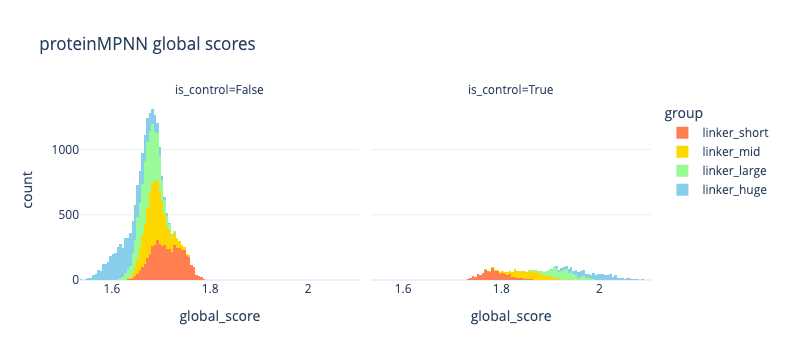

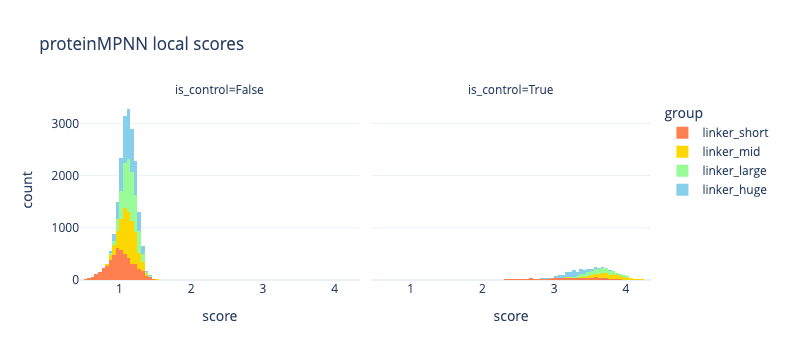

In [38]:
import pandas as pd
from pathlib import Path
import plotly.express as px
px.defaults.template = "plotly_white"

dfs = []
for path in Path('designs').glob('linker_*'):
    if not path.is_dir():
        continue
    df = seqs2df(seq_folder=path/'seqs')
    df['group'] = path.stem
    dfs.append(df)

df = pd.concat(dfs, ignore_index=True).sort_values('global_score').copy()

px.histogram(df, 'global_score', color='group', facet_col='is_control', 
            title='proteinMPNN global scores',
             category_orders={'group': 'linker_short linker_mid linker_large linker_huge'.split()},
             color_discrete_map= {'linker_short': 'coral', 
                                  'linker_mid': 'gold',
                                  'linker_large': 'palegreen',
                                  'linker_huge': 'skyblue'}
            ).show()

px.histogram(df, 'score', color='group', facet_col='is_control', 
            title='proteinMPNN local scores',
             category_orders={'group': 'linker_short linker_mid linker_large linker_huge'.split()},
             color_discrete_map= {'linker_short': 'coral', 
                                  'linker_mid': 'gold',
                                  'linker_large': 'palegreen',
                                  'linker_huge': 'skyblue'}
            ).show()

In [13]:
!cat designs/linker_huge/seqs/linker_huge_751.fa

In [39]:
!head designs/linker_huge/linker_huge_751.pdb

ATOM      1  N   SER A   1      19.513  21.768   3.434  1.00  1.00
ATOM      2  CA  SER A   1      19.456  23.143   3.915  1.00  1.00
ATOM      3  C   SER A   1      18.034  23.535   4.297  1.00  1.00
ATOM      4  O   SER A   1      17.769  23.910   5.439  1.00  1.00
ATOM      5  N   ARG A   2      17.186  23.511   3.390  1.00  1.00
ATOM      6  CA  ARG A   2      15.787  23.841   3.630  1.00  1.00
ATOM      7  C   ARG A   2      15.134  22.826   4.560  1.00  1.00
ATOM      8  O   ARG A   2      14.328  23.186   5.419  1.00  1.00
ATOM      9  N   TYR A   3      15.507  21.586   4.420  1.00  1.00
ATOM     10  CA  TYR A   3      14.947  20.538   5.264  1.00  1.00


In [226]:
from typing import Union
from pathlib import Path
import gemmi

def read_rf_pdb(path: Union[str, Path]) -> gemmi.Structure:
    """
    Gemmi has a problem with RFdiffusion pdbs as they lack sidechains,
    and will NOT assign the ``gemmi.EntityType.Polymer``.
    this allows ``chain.get_polymer().make_one_letter_sequence()`` to work.
    """
    design: gemmi.Structure = gemmi.read_structure(str(path))
    # Who are you calling smelly? Force to be a polymer
    residue: gemmi.Residue
    for residue in design[0]['A']:
        residue.entity_type = gemmi.EntityType.Polymer
    return design


import gemmi
import io
import numpy as np
import json
from typing import List, Tuple, Union, Any, Dict, Sequence
from Bio.Align import PairwiseAligner, Alignment, substitution_matrices

def get_transformation(ref_model, mob_model, residue_pairs: Sequence[Tuple[Tuple[str, int], Tuple[str, int]]]) -> gemmi.SupResult:
    ref_positions = []
    mob_positions = []
    if isinstance(residue_pairs, dict):
        residue_pairs = list(residue_pairs.items())
    for (res1, res2) in residue_pairs:
        chain_1, resnum_1 = res1
        chain_2, resnum_2 = res2
        ref_residue: gemmi.Residue = ref_model[chain_1][resnum_1]
        mob_residue: gemmi.Residue = mob_model[chain_2][resnum_2]
        assert ref_residue.name == mob_residue.name, (res1,ref_residue.name, res2, ref_residue.name) 
        ref_atom = ref_residue.get_ca()
        mob_atom = mob_residue.get_ca()
        ref_positions.append(ref_atom.pos)
        mob_positions.append(mob_atom.pos)
    
    transformation = gemmi.superpose_positions(ref_positions, mob_positions)
    return transformation

def get_rmsd(ref_model, mob_model, residue_pairs):
    return  get_transformation(ref_model, mob_model, residue_pairs).rmsd

def calculate_ref2query(ref_seq, query_seq) -> Dict[int, int]:
    aligner = PairwiseAligner()
    aligner.internal_gap_score = -2
    aligner.extend_gap_score = -0.01
    aligner.end_gap_score = -0.01
    aligner.match = 1
    aligner.mismatch = -1
    aln: Alignment = aligner.align(ref_seq, query_seq)[0]
    return {t: q for t, q in zip(aln.indices[0], aln.indices[1]) }


from Bio.SeqUtils import IUPACData

def get_masked_seq(chain: gemmi.Chain) -> str:
    """
    RFdiffusion PDB have a B-factor of 0. for the designed residues.
    This is the same as ``chain.get_polymer().make_one_letter_sequence()``,
    but adds X for the designed positions.
    """

    get_letter = lambda residue: IUPACData.protein_letters_3to1[residue.name.capitalize()]
    letters = [get_letter(residue) if residue.get_ca().b_iso != 0.0 else 'X' for residue in design['A']]
    return ''.join(letters)

import numpy as np

def model_to_numpy(model: gemmi.Model, CA_only=True) -> np.ndarray:
    """Extract atomic positions from a gemmi.Model as a NumPy array."""
    if CA_only:
        atoms: Union[gemmi.Atom, None] = [residue.get_ca() for chain in model for residue in chain]
    else:
        atoms: Union[gemmi.Atom] = [atom for chain in model for residue in chain for atom in residue]
    positions: List[List[float]] = [atom.pos.tolist() for atom in atoms if atom]
    return np.array(positions, dtype=np.float32)

In [269]:
import numpy as np
from scipy.spatial.distance import cdist

ref: gemmi.Model = read_rf_pdb('6N3O_relaxed.pdb')[0]
prior: gemmi.Model = gemmi.read_structure('prior_ligands.pdb')[0]
nogo: np.ndarray = model_to_numpy(prior, CA_only=False)

_results = []
for path in ('designs/' + df.group +'/' + df.model + '.pdb').apply(Path).to_list():
    design: gemmi.Model = read_rf_pdb(str(path))[0]
    hal_seq = get_masked_seq(design['A'])
    ref_seq = ref['A'].get_polymer().make_one_letter_sequence().replace('-', '')
    ref2query = calculate_ref2query(ref_seq=ref_seq, query_seq=hal_seq)
    mapping = [(('A', i), ('A', j)) for i, j in ref2query.items() if i != -1 and j != -1]
    design.transform_pos_and_adp(transformation.transform)
    pos = model_to_numpy(design)
    distances = cdist(pos, nogo, metric='euclidean')
    # who? set(np.where(distances < 2.0)[0])
    n_clashes = ((distances < 2.0).sum(axis=1) > 0).sum()
    if n_clashes == 0:
        out = gemmi.Structure()
        out.add_model(design)
        out.write_pdb(f'designs/shortlisted_rf/{path.stem}.pdb')
    _results.append({'name': path.stem, 'path': path, 'n_clashes': n_clashes})

In [275]:
df['n_clashes'] = df.model.map( pd.DataFrame(_results).sort_values('n_clashes').set_index('name').n_clashes.to_dict() )

In [278]:
df.sort_values(['n_clashes', 'global_score']).to_csv('proteinMPNN.csv')

In [285]:
!mkdir -p designs/af3_jobs

In [692]:
# spike-in

ref_seq = ref['A'].get_polymer().make_one_letter_sequence().replace('N-A', 'NDGA').replace('FS-EALYVSPE-Y', 'G'*15)
name = 'linked_001'

ref_seq = ref['A'].get_polymer().make_one_letter_sequence().replace('N-A', 'NDGA').replace('FS-EALYVSPE-Y', 'PG')
name = 'linked_002'

prot_sequence = dict(id='A', sequence=seq, modifications=[], unpairedMsa=None, pairedMsa=None)
other_sequences=[dict(ligand=dict(id='Z', ccdCodes=['ATP', 'MG', 'MG']))]
job = dict(name=name,
           modelSeeds=[888],
           sequences=[dict(protein=prot_sequence),
                      *other_sequences
                     ],
           dialect='alphafold3',
           version=2
          )
out_path = Path(f'designs/af3_jobs/{name}.json')
out_path.write_text( json.dumps(job) )
print(out_path)

designs/af3_jobs/linked_002.json


In [ ]:
source $DATA/mferla/waconda-slurm/etc/profile.d/conda.sh;
conda activate af3;
cd $DATA/mferla/GCN2;

python run_alphafold.py --json_path="designs/af3_jobs/linked_002.json" \
                        --output_dir=$DATA/mferla/GCN2/designs/af3_designs \
                        --db_dir=/tmp/public_databases \
                        --model_dir=/tmp/af3_weights;


In [293]:
# modified to do MSA

import pickle
import json
import os
from typing import Dict, Optional
from Bio.Align import PairwiseAligner, Alignment, substitution_matrices
from Bio import SeqIO
import io
import re

def convert_seq(seq, present2wanted, full_len):
    fragmented_seq = []
    for res in seq:
        if 97 <= ord(res) < 97 + 26:
            fragmented_seq[-1] += res
        else:
            fragmented_seq.append(res)
    new_seq = ['-' for p in range(full_len)]
    previous_wanted_idx0 = -1
    for present_idx0, wanted_idx0 in present2wanted.items():
        if present_idx0 == -1:
            pass
        if wanted_idx0 == -1 and previous_wanted_idx0 != -1:
            new_seq[previous_wanted_idx0] += fragmented_seq[present_idx0].lower().replace('-', '')
        else:
            new_seq[wanted_idx0] = fragmented_seq[present_idx0]
        previous_wanted_idx0 = wanted_idx0
    return ''.join(new_seq)

def convert_msa(design_seq, msa, present2wanted):
    """
    Given an A3M-format MSA string (``msa``) generated against a sequence differing from the desired sequence ``design_seq``,
    and a diction mapping the idx0 of residue from present sequence to the wanted seq
    """
    new_msa = f'>query\n{design_seq}\n'
    for record in SeqIO.parse(io.StringIO(msa), "fasta"):
        new_seq = convert_seq(str(record.seq), present2wanted, full_len=len(design_seq))
        new_msa += f'>{record.description}\n{new_seq}\n'
    return new_msa

def calculate_ref2query(ref_seq, query_seq) -> Dict[int, int]:
    aligner = PairwiseAligner()
    aligner.internal_gap_score = -2
    aligner.extend_gap_score = -0.01
    aligner.end_gap_score = -0.01
    aligner.match = 1
    aligner.mismatch = -1
    aln: Alignment = aligner.align(ref_seq, query_seq)[0]
    return {t: q for t, q in zip(aln.indices[0], aln.indices[1]) }

def generate_AF3_jobs(df,
                      out_folder: Path,
                      listing_path: Path,
                      chains=['A'],
                      max_job: int=-1,
                      ref_seq='',
                      ref_paired_msa='',
                      ref_unpaired_msa='',
                      other_sequences=()):
    """
    ``out_folder`` is for the json: the designs are specified by AF3
    """
    os.makedirs(out_folder, exist_ok=True)
    job_list = []
    for i, row in df.reset_index().iterrows():
        if row.is_control:
            break
        if i == max_job:
            break
        name = row.model+row.letter
        out_path = Path(out_folder) / f'{name}.json'
        sequence = row.seq
        prot_sequence = dict(id=chains,
                             sequence=sequence, modifications=[], unpairedMsa=None, pairedMsa=None)      
        if ref_seq:
            ref2query = calculate_ref2query(ref_seq, sequence)
            if ref_paired_msa:
                prot_sequence['pairedMsa'] = convert_msa(sequence, ref_paired_msa, ref2query)
            else:
                prot_sequence['pairedMsa'] = ''
            if ref_unpaired_msa:
                prot_sequence['unpairedMsa'] = convert_msa(sequence, ref_unpaired_msa, ref2query)
            else:
                prot_sequence['unpairedMsa'] = ''
        job = dict(name=name,
                   modelSeeds=[888],
                   sequences=[dict(protein=prot_sequence),
                              *other_sequences
                             ],
                   dialect='alphafold3',
                   version=2
                  )
        out_path.write_text( json.dumps(job) )
        job_list.append(out_path.as_posix())
    listing_path.write_text('\n'.join(job_list))
    return job_list



In [292]:
d = json.load(open('designs/af3_designs/linked_001/linked_001_data.json'))
ref_paired_msa = d['sequences'][0]['protein']['pairedMsa']
ref_unpaired_msa = d['sequences'][0]['protein']['unpairedMsa']
Path('WT_paired.a3m').write_text(ref_paired_msa)
Path('WT_unpaired.a3m').write_text(ref_unpaired_msa)

6283661

In [ ]:
df['original_seq'] = df.seq
df['seq'] = df.seq.replace('YNAWIENAVHYLYIQ', 'YNAWIENDGAVHYLYIQ')

In [322]:
df['af3_done'] = (df.model + df.letter.str.lower()).apply(lambda name: Path(f'designs/af3_designs/{name}').exists())

In [323]:
df['af3_done'].sum()

494

In [325]:
sub.group.value_counts()

group
linker_mid      2054
linker_short    1206
linker_huge     1165
linker_large     730
Name: count, dtype: int64

In [326]:
for group in ('short','mid','large','huge'):
    sub = df.loc[(df.n_clashes == 0) & (df.group == f'linker_{group}')]
    cutoff_global_score = sub.global_score.loc[sub.is_control].min()
    cutoff_score = sub.score.loc[sub.is_control].min()
    okay = sub.loc[(sub.global_score < cutoff_global_score) & (sub.score < cutoff_score)]

    jobs = generate_AF3_jobs(okay.loc[~okay.af3_done].head(100), 
                        out_folder=Path('designs/af3_jobs'), 
                        listing_path=Path(f'designs/jobs_{group}.txt'),
                        chains=['A'],
                        ref_seq=ref_seq,
                        ref_paired_msa=ref_paired_msa,
                          ref_unpaired_msa=ref_unpaired_msa,
                        other_sequences=other_sequences,
    )
    print(len(jobs))

100
100
100
100


In [327]:
import random

jobs = []
for group in ('short','mid','large','huge'):
    jobs.extend( Path(f'designs/jobs_{group}.txt').read_text().split('\n') )

random.shuffle(jobs)
Path(f'designs/jobs.txt').write_text('\n'.join(jobs))

15644

In [ ]:
sleep 30m
touch 'STOP';
rm 'STOP';
while IFS= read -r JSON_JOB; do
    # Check if STOP file exists
    if [[ -f STOP ]]; then
        echo "STOP file detected. Exiting loop.";
        break
    fi
    # hyphens are not bleached
    LOWERCASED=$(echo $(basename "$JSON_JOB" .json) | tr '[:upper:]' '[:lower:]');
    if [[ -f "af3_designs/${LOWERCASED}/${LOWERCASED}_model.cif" ]]; then
        echo "${JSON_JOB} DONE ALREADY";
        continue
    fi
    echo $JSON_JOB
    python run_alphafold.py --json_path="$JSON_JOB" \
        --output_dir=$DATA/mferla/designs/af3_designs \
        --db_dir=/tmp/public_databases \
        --model_dir=/tmp/af3_weights;
done < designs/jobs.txt


## AF3 PyRosetta analysis

In [605]:
import re
import io


def extract_pose_table(path):
    block = path.read_text().strip()
    start = block.find('#BEGIN_POSE_ENERGIES_TABLE')
    assert start != -1, f'{path} is not a pyrosetta minimised structure'
    end = block.find('#END_POSE_ENERGIES_TABLE')
    block = block[start:end]
    return pd.read_csv(io.StringIO(block), skiprows=1, delimiter=' ')

def calc_rmsds(path_rf, path_af3):
    rf: gemmi.Structure = gemmi.read_structure(str(path_rf))
    af: gemmi.Structure = gemmi.read_structure(str(path_af3))
    rfA: gemmi.Chain = rf[0]['A']
    afA: gemmi.Chain = af[0]['A']
    assert len(rfA) == len(afA)
    # align by conserved
    con_mask: List[bool] = [resi.sole_atom('CA').b_iso > 0. for resi in rfA]
    con_ref_positions: List[gemmi.Position] = [resi.sole_atom('CA').pos for masked, resi in zip(con_mask, rfA) if masked]
    con_mob_positions: List[gemmi.Position] = [resi.sole_atom('CA').pos for masked, resi in zip(con_mask, afA) if masked]
    transformation: gemmi.SupResult = gemmi.superpose_positions(con_ref_positions, con_mob_positions)
    con_rmsd = transformation.rmsd
    af[0].transform_pos_and_adp(transformation.transform)
    # calculate rmsd of designed (w/o superposition)
    hal_ref_positions: List[gemmi.Position] = [resi.sole_atom('CA').pos for masked, resi in zip(con_mask, rfA) if not masked]
    hal_mob_positions: List[gemmi.Position] = [resi.sole_atom('CA').pos for masked, resi in zip(con_mask, afA) if not masked]
    # Unfortunately, RFdiffusion models do not register as polymertype.PeptideL
    #sup = gemmi.calculate_current_rmsd(rfA.get_subchain('A'), afA.get_subchain('A'), gemmi.PolymerType.PeptideL, gemmi.SupSelect.CaP)
    distances = np.array([r.dist(m) for r, m in zip(hal_ref_positions, hal_mob_positions)])
    hal_rmsd = np.sqrt((distances**2).sum())
    # mod structure
    df = extract_pose_table(path_af3)  # this is a pyrosetta minimised AF3
    for masked, resi in zip(con_mask, afA):
        min_score = df['total'].iloc[2:].min()
        max_score = df['total'].iloc[2:].max()
        for score, atom in zip(df['total'].iloc[2:], resi):
            atom.occ = 1 if masked else 0.5
            atom.b_iso = (float(score) - min_score) / (max_score - min_score) * 10
    return {'model': af.make_pdb_string(), 'con_rmsd': con_rmsd, 'hal_rmsd': hal_rmsd, 'con_mask': con_mask} 
    
_scores = {}
for path in Path('designs/af3_relaxed').glob('*.pdb'):
    # rosetta files have scores in comments.
    for line in path.read_text().split('\n'):
        if not line.strip():
            continue
        parts = line.split()
        if parts[0] == 'label':
            header = parts[1:]
        elif parts[0] == 'pose':
            _scores[path.stem] = dict( zip(header, map(float, parts[1:])) )
            break

scores = pd.DataFrame(_scores).T.sort_values('total').reset_index(names='design_name').copy()

In [606]:
_rmsds = {}
for af3_path in Path('designs/af3_relaxed').glob('*.pdb'):
    group = '_'.join(af3_path.stem.split('_')[:-1])
    rf_folder = Path('designs') / group
    rf_path = rf_folder / (af3_path.stem[:-1]+'.pdb')
    if not rf_path.exists():
        print(rf_path)
        continue
    info = calc_rmsds(path_rf=rf_path, path_af3=af3_path) # ['model', 'con_rmsd', 'hal_rmsd', 'con_mask']
    del info['model']
    _rmsds[af3_path.stem] = info
    
rmsds = pd.DataFrame(_rmsds).T.sort_values('hal_rmsd').reset_index(names='design_name').copy()

designs/linked/linked_00.pdb


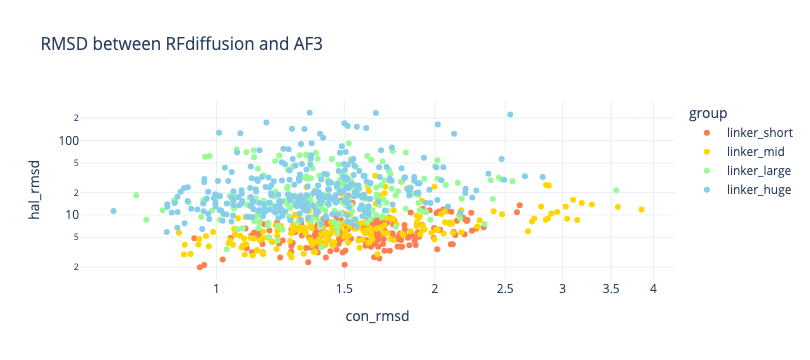

In [617]:
rmsds['group'] = rmsds.design_name.apply(lambda n: '_'.join(n.split('_')[:-1]))
fig = px.scatter(rmsds, x="con_rmsd", y="hal_rmsd",
                 color='group',
                 category_orders={'group': 'linker_short linker_mid linker_large linker_huge'.split()},
                 color_discrete_map= {'linker_short': 'coral', 
                                      'linker_mid': 'gold',
                                      'linker_large': 'palegreen',
                                      'linker_huge': 'skyblue'},
                 hover_name='design_name',
                 log_x=True,
                 log_y=True,
                 title="RMSD between RFdiffusion and AF3")
fig.show()

In [618]:
full_df = pd.merge(scores, rmsds, on='design_name')

In [351]:
## Boilerplate imports

import pandas as pd
from pathlib import Path
import json
import pyrosetta
import pyrosetta_help as ph
from types import ModuleType
# Better than star imports:
prc: ModuleType = pyrosetta.rosetta.core
prp: ModuleType = pyrosetta.rosetta.protocols
pru: ModuleType = pyrosetta.rosetta.utility
prn: ModuleType = pyrosetta.rosetta.numeric
prs: ModuleType = pyrosetta.rosetta.std
pr_conf: ModuleType = pyrosetta.rosetta.core.conformation
pr_scoring: ModuleType = pyrosetta.rosetta.core.scoring
pr_res: ModuleType = pyrosetta.rosetta.core.select.residue_selector
pr_options: ModuleType = pyrosetta.rosetta.basic.options

logger = ph.configure_logger()
pyrosetta.distributed.maybe_init(extra_options=ph.make_option_string(no_optH=False,
                                                                     ex1=None,
                                                                     ex2=None,
                                                                     ignore_unrecognized_res=False,
                                                                     load_PDB_components=True,
                                                                     ignore_waters=True,
                                                                    )
                                )    

In [353]:
af_folder = Path(f'designs/af3_relaxed')


def make_conserved_selector(trb) -> pr_res.ResidueSelector:
    con = pr_res.ResidueIndexSelector()
    for chain, idx1 in trb['con_hal_pdb_idx']:
        # technically, the numbering is reset by AF3 again, but the same way 1 onwards
        con.append_index(idx1)
    return con

def make_novel_selector(trb) -> pr_res.ResidueSelector:
    con = make_conserved_selector(trb)
    novel = pr_res.AndResidueSelector(pr_res.NotResidueSelector(con), pr_res.ChainSelector('A'))
    return novel

def get_novel_itx_resi(pose, trb, threshold=3.5) -> pru.vector1_unsigned_long:
    novel = make_novel_selector(trb)
    contacts = pr_res.CloseContactResidueSelector()
    contacts.central_residue_group_selector(novel)
    contacts.threshold(threshold)
    return pr_res.ResidueVector( contacts.apply(pose) )

def get_neighbors(design_name):
    """
    These are in REF numbering
    """
    try:
        af3_path = af_folder / f'{design_name}.pdb'
        if not af3_path.exists():
            print(f'missing {design_name}')
            return []
        pose = pyrosetta.pose_from_pdb(str(af3_path))
        hallucination_name = af3_path.stem[:-1]
        datum = dict(design_name=af3_path.name, hallucination_name=hallucination_name)
        # trb derived
        group = '_'.join(design_name.split('_')[:-1])
        rf_folder = Path('designs') / group
        trb_path = rf_folder / (hallucination_name+'.trb')
        trb: dict = pickle.load(trb_path.open('rb'))
        neighs = get_novel_itx_resi(pose, trb)
        hal2ref = dict(zip(trb['con_hal_pdb_idx'], trb['con_ref_pdb_idx']))
        return [hal2ref['A', idx1][1] for idx1 in neighs if ('A', idx1) in hal2ref]
    except Exception as error:
        print(error)
        return []

full_df['intxns@ref'] = full_df.design_name.apply(get_neighbors)

In [619]:
# missing values due to error..
#ir = full_df.set_index('design_name')['intxns@ref'].to_dict()
full_df['intxns@ref'] = full_df.design_name.apply(lambda name: ir[name] if name in ir else get_neighbors(name))

In [620]:
full_df['n_intxns'] = full_df['intxns@ref'].apply(len)

In [621]:
full_df['group'] = full_df.design_name.apply(lambda n: '_'.join(n.split('_')[:-1]))

In [622]:
import numpy as np
import pandas as pd
from sklearn.manifold import MDS
from sklearn.metrics import pairwise_distances
import plotly.express as px

idxs = set(np.concatenate(full_df['intxns@ref'].values))
bool_itxns = pd.DataFrame({name: {idx1: idx1 in l for idx1 in idxs} for name, l in full_df.set_index('design_name')['intxns@ref'].items()}).T
distance_matrix = pairwise_distances(bool_itxns.values, metric="jaccard")

mds = MDS(n_components=2, dissimilarity="precomputed", random_state=42)
mds_coords = mds.fit_transform(distance_matrix)

df_mds = pd.DataFrame(mds_coords, columns=["MDS1", "MDS2"])
fig = px.scatter(df_mds, x="MDS1", y="MDS2",
                 color=full_df['group'],
                 category_orders={'group': 'linker_short linker_mid linker_large linker_huge'.split()},
                 color_discrete_map= {'linker_short': 'coral', 
                                      'linker_mid': 'gold',
                                      'linker_large': 'palegreen',
                                      'linker_huge': 'skyblue'},
                 template='plotly_white',
                 size=full_df['n_intxns'],
                 size_max=full_df['n_intxns'].max() / 10,
                 hover_name=full_df['design_name'],
                 title="Interaction diversity (3.5Å cutoff, Jaccard distance)")
fig.show()

In [623]:
ixtn_hotness = bool_itxns.sum()
m = ixtn_hotness.max()
cmds = 'color white;\n'
for i in range(1, m+1):
    g = 255
    n = ixtn_hotness[ ixtn_hotness == i ].index.to_list()
    if n:
        r = int(min((i / m) * 256, 255))
        b = r
        cmds += f'color 0x{r:0<2x}{g:0<2x}{b:0<2x}, resi {"+".join(map(str, n))};\n'
Path('pymol_cmd.txt').write_text(cmds)

1963

In [624]:
full_df['n_hairpin_itxns'] = full_df['intxns@ref'].apply(lambda l: sum([1 for n in l if 595 <= int(n) <=605]))
full_df['n_hairpin_side_itxns'] = full_df['intxns@ref'].apply(lambda l: sum([1 for n in l if 595 <= int(n) <=600]))

In [625]:
fig = px.violin(full_df, x=full_df.n_hairpin_itxns.astype(bool), y='total',
                 color=full_df['group'],
                 category_orders={'group': 'linker_short linker_mid linker_large linker_huge'.split()},
                 color_discrete_map= {'linker_short': 'coral', 
                                      'linker_mid': 'gold',
                                      'linker_large': 'palegreen',
                                      'linker_huge': 'skyblue'},
                 box=True,
                 template='plotly_white',
                 hover_name=full_df['design_name'],
                 labels={'x': 'Forms iteraction with hairpin'},
                 title="Interaction diversity (3.5Å cutoff, Jaccard distance)")
fig.show()

In [626]:
#full_df.loc[(full_df.n_hairpin_side_itxns > 0) & (full_df.hal_rmsd < 10) & (full_df.total < wt_dG)]

In [627]:
ssdex = globals().get('ssdex', {})
seqs = globals().get('seqs', {})
for pdb_path in Path('designs/af3_relaxed').glob('*.pdb'):
    if pdb_path.stem in seqs:
        continue
    pose = pyrosetta.pose_from_pdb(pdb_path.as_posix())
    dss = pyrosetta.rosetta.core.scoring.dssp.Dssp(pose).get_dssp_secstruct()
    ssdex[pdb_path.stem] = dss
    seqs[pdb_path.stem] = pose.sequence()

In [628]:
full_df['SS'] = full_df.design_name.map(ssdex)
full_df['sequence'] = full_df.design_name.map(seqs)

In [629]:
def calc_novelty(sequence):
    query2ref = calculate_ref2query(sequence.upper(), ref_seq)
    return [query2ref[k] == -1 for k in range(len(sequence))]

def camelize(sequence):
    novelty = calc_novelty(sequence)
    return ''.join([r if n else r.lower() for r, n in zip(sequence, novelty)]).replace('Z','')


full_df['camelized_sequence'] = full_df.sequence.apply(camelize)

In [630]:
full_df.to_pickle('af3_scored.pkl')

In [631]:
calc_n_designed = lambda row: sum([1 for res in row.camelized_sequence if res.isupper()])
full_df['n_designed'] = full_df.apply(calc_n_designed, axis=1)

calc_loopiness = lambda row: sum([sec == 'L' for sec, res in zip(row.SS, row.camelized_sequence) if res.isupper()])
full_df['loopiness'] = full_df.apply(calc_loopiness, axis=1)

In [632]:
px.density_heatmap(full_df,
                   'n_designed', 'loopiness', 
                   title='N designed residues vs N designed residues with "Loop" SS',
                   facet_col='group', color_continuous_scale='blues')

In [633]:
px.scatter(x=full_df.loopiness, y=full_df.n_designed, color=full_df.group, opacity=0.2).show()

from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(full_df.n_designed.values.reshape(-1, 1), full_df.loopiness.values, )


slope = model.coef_[0]
intercept = model.intercept_
print(slope, intercept)

0.2358489221369216 4.320166714465461


In [580]:
364

'LLLLH'

In [584]:
sum((full_df.hal_rmsd < 15) & (full_df.total < wt_dG) )

364

In [634]:
keepers = []

In [679]:
wt_dG = -864.993

# print('best RMSD')
# print(sum((full_df.hal_rmsd < 10) & (full_df.total < wt_dG)))
# sub = full_df.loc[(full_df.hal_rmsd < 10) & (full_df.total < wt_dG)].sort_values('hal_rmsd').head(5)

print('most hairpin')
sub = full_df.loc[(full_df.hal_rmsd < 10) & (full_df.total < wt_dG)].sort_values('n_hairpin_side_itxns', ascending=False).head(5)

#sub = full_df.loc[(full_df.hal_rmsd < 20) & (full_df.total < wt_dG)].sort_values('n_hairpin_side_itxns', ascending=False).head(5)

#sub = full_df.loc[(full_df.hal_rmsd < 20) & (full_df.total < wt_dG) & (full_df.n_hairpin_side_itxns > 0)].sort_values('total')

print('not loopy')
print(sum((full_df.hal_rmsd < 10) & (full_df.total < wt_dG) & (full_df.SS.str.slice(147,152) != ('L' * 5))))
sub = full_df.loc[(full_df.hal_rmsd < 10) & (full_df.total < wt_dG) & (full_df.SS.str.slice(147,152) != ('L' * 5)) & (full_df.n_hairpin_side_itxns > 0)].sort_values(['n_hairpin_side_itxns', 'total'], ascending=[False, True]).head(5)


keepers.extend( sub.design_name.to_list() )

print(
sub\
[['design_name', 'total', 'hal_rmsd', 'n_designed', 'loopiness', 'n_intxns', 'n_hairpin_itxns','n_hairpin_side_itxns', 'camelized_sequence']]\
.to_markdown(index=False)
)

most hairpin
not loopy
57
| design_name       |     total |   hal_rmsd |   n_designed |   loopiness |   n_intxns |   n_hairpin_itxns |   n_hairpin_side_itxns | camelized_sequence                                                                                                                                                                                                                                                                                 |
|:------------------|----------:|-----------:|-------------:|------------:|-----------:|------------------:|-----------------------:|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| linker_huge_116d  | -1051.72  |    9.47575 |           60 |          10 |         41 |                 3 |            

In [684]:
full_df.to_csv('results.csv')

In [598]:
full_df.set_index('design_name').loc['linker_huge_639a'].camelized_sequence[147:152]

'ALPSA'

In [691]:
# NOT DONE YET

# copypaste from USP11 from dengue

import tarfile, io



# def encode_structure(in_path, out_path, occupancies, temperatures) -> str:
#     structure = gemmi.read_structure(str(in_path))
#     for residue, occ, temp in zip(structure[0]['A'], occupancies, temperatures):
#         for atom in residue:
#             atom.occ = min(max(occ, 0.5), 1.)
#             atom.b_iso = temp
#     return structure.make_pdb_string()

min_folder = Path('designs/af3_relaxed')
with tarfile.open('valid_designs.tar.gz', "w:gz") as tar:
    for i, row in full_df.loc[(full_df.hal_rmsd < 15) & (full_df.total < wt_dG) & (full_df.n_hairpin_itxns > 0)]\
                .drop_duplicates('design_name')\
                .reset_index() \
                .iterrows():
        # novelty = calc_novelty(row.sequence)
        # pdbblock = encode_structure(in_path=min_folder / (row['design_name'] + '.pdb'),
        #                      out_path= out_path,
        #                      occupancies=1 - np.array(novelty) / 2,
        #                      temperatures=np.array(row.resi_scores) + 10 )
        tar.add(str(min_folder / (row['design_name'] + '.pdb')))

In [121]:
# # align by conserved
# con_mask: List[bool] = [resi.sole_atom('CA').b_iso > 0. for resi in design]
#     con_ref_positions: List[gemmi.Position] = [resi.sole_atom('CA').pos for masked, resi in zip(con_mask, design) if masked]
#     con_mob_positions: List[gemmi.Position] = [resi.sole_atom('CA').pos for masked, resi in zip(con_mask, ref) if masked]
#     transformation: gemmi.SupResult = gemmi.superpose_positions(con_ref_positions, con_mob_positions)
#     con_rmsd = transformation.rmsd
#     af[0].transform_pos_and_adp(transformation.transform)

,design_name,con_rmsd,hal_rmsd,con_mask
0,linker_short_243a,1.501895,2.137781,"[True, True, True, True, True, True, True, Tru..."
1,linker_short_383a,1.337895,2.317414,"[True, True, True, True, True, True, True, Tru..."
2,linker_short_243c,1.676853,2.597156,"[True, True, True, True, True, True, True, Tru..."
3,linker_short_184a,1.22387,2.670517,"[True, True, True, True, True, True, True, Tru..."
4,linker_short_393a,1.414761,2.683771,"[True, True, True, True, True, True, True, Tru..."
...,...,...,...,...
575,linker_huge_727b,1.500178,171.397947,"[True, True, True, True, True, True, True, Tru..."
576,linker_huge_39a,1.171401,175.014279,"[True, True, True, True, True, True, True, Tru..."
577,linker_huge_23b,2.539916,224.421339,"[True, True, True, True, True, True, True, Tru..."
578,linker_huge_23c,1.658419,234.943904,"[True, True, True, True, True, True, True, Tru..."


In [69]:

design[0]['A'].get_polymer().make_one_letter_sequence()

'SRYFIEFEELQLLGKGAFGAVIKVQNKLDGCCYAVKRIPINPASRQFRRIKGEVTLLSRLHHENIVRYYNAWIEN-AVHYLYIQMEYCEASTLRDTIDQGLYRDTVRLWRLFREILDGLAYIHEKGMIHRNLKPVNIFLDSDDHVKIGDFGLATDHLAFS-EALYVSPE-YNQKVDLFSLGIIFFEMSYHPMVTASERIFVLNQLRDPTSPKFPEDFDDGEHAKQKSVISWLLNHDPAKRPTATELLKSELLPPP'

In [58]:
design[0]['A'].get_ligands(),design[0]['A'].get_polymer()

(<gemmi.ResidueSpan of 0: []>,
 <gemmi.ResidueSpan of 265:  [1(SER) 2(ARG) 3(TYR) ... 265(PRO)]>)

In [52]:
design[0]['A'][0].het_flag

'A'

In [604]:
for path in Path('../designs/af3_designs').glob('*'):
    if not Path(f'../designs/af3_designs/{path.name}/{path.name}_model.cif').exists():    
        print(path.name)
        continue
    !mv ../designs/af3_designs/{path.name} designs/af3_designs/

In [603]:
!ls designs/af3_designs/linker_mid_800a

ls: cannot access 'designs/af3_designs/linker_mid_800a/': No such file or directory
